In [1]:
%matplotlib inline 
#%load excesses.py

import pandas as pd
import numpy as np
import matplotlib.dates as dates
import matplotlib.pyplot as plt

In [2]:
# bring in the data in csv form
filename = "excess-mortality-raw-death-count-5.csv"
data = pd.read_csv(filename)
#print(data.columns)

# Columns
#--------------------------------------
#Entity - United States
#Code - USA
#Date - 2020-08-30
#"Deaths, 2020, all ages" - 56575
#"Average deaths, 2015–2019, all ages"
#deaths_2015_all_ages - 51735
#deaths_2016_all_ages - 51272
#deaths_2017_all_ages - 51272
#deaths_2018_all_ages - 51272
#deaths_2019_all_ages - 51272


In [3]:
# make sure the dates are formatted properly
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d")

# set Country and Date as indexes
data = data.set_index(["Entity", "Date"]).sort_index()

# rename columns for better readability
data.columns = ["Code", "2020", "Average", "2015", "2016", "2017", "2018", "2019"]

In [4]:
# pick which columns to keep
data = data[["Average", "2020", "2019", "2018", "2017", "2016", "2015"]]

In [5]:
# Look at only US data
country = data.loc["United States"]
country = country.copy()
print(country)

            Average     2020   2019   2018   2017   2016     2015
Date                                                             
2020-01-05  60340.4  60009.0  58298  66129  59760  55784  61731.0
2020-01-12  60696.4  60551.0  58358  67491  60975  55523  61135.0
2020-01-19  59188.8  59190.0  58217  64641  59286  55178  58622.0
2020-01-26  58318.4  58991.0  57904  62777  58045  55602  57264.0
2020-02-02  57943.0  58795.0  58149  60972  58426  54891  57277.0
2020-02-09  58035.6  59360.0  58519  61107  59036  55103  56413.0
2020-02-16  57673.4  58770.0  57997  59774  58473  55781  56342.0
2020-02-23  56919.4  58852.0  58004  57790  58282  54862  55659.0
2020-03-01  56700.6  59262.0  57968  56690  57250  55871  55724.0
2020-03-08  56893.4  59646.0  58542  57089  57468  56106  55262.0
2020-03-15  55917.6  58618.0  57916  56317  56650  54452  54253.0
2020-03-22  55556.0  59156.0  57092  55758  57041  54660  53229.0
2020-03-29  54831.6  62943.0  56672  54913  55695  53879  52999.0
2020-04-05

In [6]:
# show the sum over the columns
# dropping the last 6 rows due to incomplete data to compare for 2020
print(country.drop(country.tail(6).index).sum(0))

Average    2446576.0
2020       2848224.0
2019       2503108.0
2018       2496783.0
2017       2461625.0
2016       2392472.0
2015       2378892.0
dtype: float64


In [7]:
# show the sum for all rows to compare full year (without all of 2020)
print(country.sum(0))

Average    2779872.6
2020       2848224.0
2019       2845588.0
2018       2831571.0
2017       2804035.0
2016       2725471.0
2015       2692698.0
dtype: float64


In [8]:
# get amount off the average (excess)
country.loc[:,("2020_excess")] = country["2020"] - country["Average"]
country.loc[:,("2019_excess")] = country["2019"] - country["Average"]
country.loc[:,("2018_excess")] = country["2018"] - country["Average"]

# show excess percents
country.loc[:,("2020_excess_percent")] = country["2020_excess"] / country["Average"] * 100

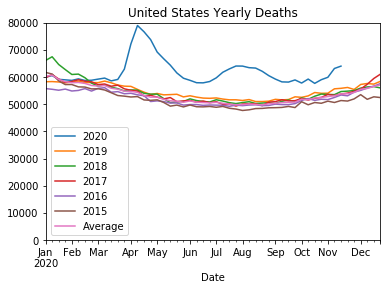

In [9]:
# plot graph of yearly deaths
fig, ax = plt.subplots()
plt.title("United States Yearly Deaths")
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%d/%Y'))
country.plot(y=["2020", "2019", "2018", "2017", "2016","2015", "Average"], kind="line", ax=ax, ylim=(0, 80000))
plt.show()

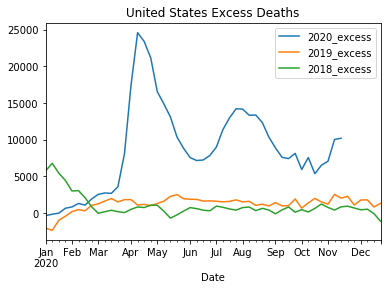

In [10]:
fig, ax = plt.subplots()
plt.title("United States Excess Deaths")
ax.xaxis.set_major_formatter(dates.DateFormatter("%m/%d/%Y"))
country.plot(y=["2020_excess", "2019_excess", "2018_excess"], kind="line", ax=ax)
plt.show()

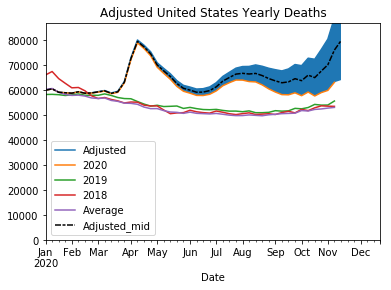

In [11]:
# probabilistic scale factor for possible deaths not yet reported
# https://www.cdc.gov/nchs/data/vsrr/report001.pdf
prob = [
        0.0,
        4.8, 27.2, 43.8, 54.1, 61.9, 67.0, 71.0,
        74.5, 77.4, 79.7, 81.4, 82.8, 83.9, 84.9,
        86.0, 86.9, 88.0, 89.3, 90.3, 91.3, 92.2,
        93.1, 93.8, 94.3, 94.8, 95.2, 95.5, 95.8,
        96.0, 96.2, 96.4, 96.7, 97.1, 97.5, 97.9,
        98.3, 98.6, 98.9, 99.1, 99.3, 99.5, 99.6,
        99.7, 99.8, 99.9, 99.9, 99.9, 100.0, 100.0,
        100.0, 100.0, 100.0
        ]

# Add column for probabilistic death count
adjusted = [0] + prob
country["Reported"] = np.array(adjusted[-2:-54:-1])
country["Adjusted"] = (country["2020"].fillna(0) / country["Reported"] * 100.0).fillna(0).astype(int)
country["Adjusted_excess"] = country["Adjusted"] - country["Average"]
country["Adjusted_excess_percent"] = country["Adjusted_excess"] / country["Average"] * 100

country["Adjusted_mid"] = (country["Adjusted"] + country["2020"]) / 2

fig, ax = plt.subplots()
plt.title("Adjusted United States Yearly Deaths")
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%d/%Y'))
country.drop(country.tail(7).index).plot(y=["Adjusted", "2020", "2019", "2018", "Average"], kind="line", ax=ax)
ax.fill_between(country.drop(country.tail(6).index).index, country.drop(country.tail(6).index)["2020"], country.drop(country.tail(6).index)["Adjusted"])
country.plot(y="Adjusted_mid", kind="line", dashes=[4,1,2,1], color="black", ax=ax, ylim=(0, 87000))
plt.show()

In [12]:
print(country[["2020", "2019", "2018", "Average", "Reported"]])

               2020   2019   2018  Average  Reported
Date                                                
2020-01-05  60009.0  58298  66129  60340.4     100.0
2020-01-12  60551.0  58358  67491  60696.4     100.0
2020-01-19  59190.0  58217  64641  59188.8     100.0
2020-01-26  58991.0  57904  62777  58318.4     100.0
2020-02-02  58795.0  58149  60972  57943.0      99.9
2020-02-09  59360.0  58519  61107  58035.6      99.9
2020-02-16  58770.0  57997  59774  57673.4      99.9
2020-02-23  58852.0  58004  57790  56919.4      99.8
2020-03-01  59262.0  57968  56690  56700.6      99.7
2020-03-08  59646.0  58542  57089  56893.4      99.6
2020-03-15  58618.0  57916  56317  55917.6      99.5
2020-03-22  59156.0  57092  55758  55556.0      99.3
2020-03-29  62943.0  56672  54913  54831.6      99.1
2020-04-05  72231.0  56596  55285  54756.6      98.9
2020-04-12  78991.0  55486  55223  54378.0      98.6
2020-04-19  76671.0  54463  54031  53261.6      98.3
2020-04-26  73806.0  53655  53719  52628.0    